# Homework #6
Name: Gunhoo Park  
USC ID: 8585425433  
Github username: gunhoo

In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
from sklearn.model_selection import LeaveOneOut, GridSearchCV,StratifiedKFold ,KFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# 1. Tree-Based Methods

## (a) Download the APS Failure data from: https://archive.ics.uci.edu/ml/datasets/APS+FAILURE+at+Scania+Trucks. The dataset contains a training set and a test set. THe training set contains 60,000 rows, of which 1,000 belong to the positive class and 171 columns, of which one is the class column. All attributes are numeric.

In [5]:
training_set = '../data/aps+failure+at+scania+trucks/aps_failure_training_set.csv'
testing_set = '../data/aps+failure+at+scania+trucks/aps_failure_test_set.csv'
train_df = pd.read_csv(training_set, skiprows=20, na_values='na')
test_df = pd.read_csv(testing_set, skiprows=20, na_values='na')
train_df

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,neg,12,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,neg,60874,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,neg,153002,NaN,6.640000e+02,186.0,0.0,0.0,0.0,0.0,0.0,...,998500.0,566884.0,1290398.0,1218244.0,1019768.0,717762.0,898642.0,28588.0,0.0,0.0
59996,neg,2286,NaN,2.130707e+09,224.0,0.0,0.0,0.0,0.0,0.0,...,10578.0,6760.0,21126.0,68424.0,136.0,0.0,0.0,0.0,0.0,0.0
59997,neg,112,0.0,2.130706e+09,18.0,0.0,0.0,0.0,0.0,0.0,...,792.0,386.0,452.0,144.0,146.0,2622.0,0.0,0.0,0.0,0.0
59998,neg,80292,NaN,2.130706e+09,494.0,0.0,0.0,0.0,0.0,0.0,...,699352.0,222654.0,347378.0,225724.0,194440.0,165070.0,802280.0,388422.0,0.0,0.0


## (b) Data Preparation: This data set has missing values. When the number of data with missing values is significant, discarding them is not a good idea.

### i. Research what types of techniques are usually used for dealing with data with missing values. Pick at least one of them and apply it to this data in the next steps.

Source: https://www.datacamp.com/tutorial/techniques-to-handle-missing-data-values

0. Data Dropping: Remove missing values, which can be especailly dangerous for the rest of the analysis.
1. Mean/Median Imputation: Replace missing values with the mean/median value of the remaining data.
   * Simple and easy to implement.
   * Cannot apply these to categorical columns, but only work for numerical ones.
3. Random Sample Imputation: Randomly select from subsets
   * Tackles both numerical and categorical data types
   * The randomness does not necessarily work for all circumstances, and this can lead to incorrect statistical conclusions.
4. Multiple Imputation: The missing values are filled by taking into consideration the information from the other columns.
   * Powerful in multiple variables and multiple data types and this can work much better than mean/median approaches.
   * Complex and computationally expensive when working with large datasets.
   * Regression Imputation: Use regression method to replace missing values.
   * KNN Imputation: Replace missing values using k-nearest neighbors method.

  
| Type of missing data         | Imputation                                          |
| ---------------------------- | --------------------------------------------------- |
| Missing Completely At Random | Mean, Median, Mode, or any other imputation method  |
| Missing At Random            | Multiple imputation, Regression imputation          |
| Missing Not At Random        | Pattern Substitution, Maximum Likelihood estimation |

In this problem, we can use mean imputation since all attributes of the datasets are numeric and the dataset is highly large.

In [9]:
# Source: https://scikit-learn.org/1.5/modules/generated/sklearn.impute.SimpleImputer.html
def imputer(df):
    imputer = SimpleImputer(strategy='mean', missing_values=np.nan)
    model = imputer.fit_transform(df)
    output = pd.DataFrame(model, columns=df.columns)
    return output

In [10]:
train_X = train_df.iloc[:, 1:]
train_y = train_df.iloc[:, :1].replace({'neg': 0, 'pos': 1}).astype(int)

test_X = test_df.iloc[:, 1:]
test_y = test_df.iloc[:, :1].replace({'neg': 0, 'pos': 1}).astype(int)

C:\Users\gunho\AppData\Local\Temp\ipykernel_32872\857921058.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_y = train_df.iloc[:, :1].replace({'neg': 0, 'pos': 1}).astype(int)
C:\Users\gunho\AppData\Local\Temp\ipykernel_32872\857921058.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_y = test_df.iloc[:, :1].replace({'neg': 0, 'pos': 1}).astype(int)


In [11]:
imputed_train_x_df = imputer(train_X)
imputed_test_x_df = imputer(test_X)

In [12]:
imputed_train_x_df

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,76698.0,0.713189,2.130706e+09,280.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,33058.0,0.713189,0.000000e+00,190620.639314,0.0,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,41040.0,0.713189,2.280000e+02,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,12.0,0.000000,7.000000e+01,66.000000,0.0,10.0,0.0,0.0,0.0,318.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,60874.0,0.713189,1.368000e+03,458.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,153002.0,0.713189,6.640000e+02,186.000000,0.0,0.0,0.0,0.0,0.0,2564.0,...,998500.0,566884.0,1290398.0,1218244.0,1019768.0,717762.0,898642.0,28588.0,0.0,0.0
59996,2286.0,0.713189,2.130707e+09,224.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,10578.0,6760.0,21126.0,68424.0,136.0,0.0,0.0,0.0,0.0,0.0
59997,112.0,0.000000,2.130706e+09,18.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,792.0,386.0,452.0,144.0,146.0,2622.0,0.0,0.0,0.0,0.0
59998,80292.0,0.713189,2.130706e+09,494.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,699352.0,222654.0,347378.0,225724.0,194440.0,165070.0,802280.0,388422.0,0.0,0.0


In [13]:
imputed_test_x_df

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,60.0,0.000000,2.000000e+01,12.0,0.0,0.0,0.0,0.0,0.0,2682.0,...,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0
1,82.0,0.000000,6.800000e+01,40.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0
2,66002.0,2.000000,2.120000e+02,112.0,0.0,0.0,0.0,0.0,0.0,199486.0,...,495076.0,380368.0,440134.0,269556.0,1315022.0,153680.0,516.0,0.0,0.0,0.0
3,59816.0,0.772065,1.010000e+03,936.0,0.0,0.0,0.0,0.0,0.0,0.0,...,540820.0,243270.0,483302.0,485332.0,431376.0,210074.0,281662.0,3232.0,0.0,0.0
4,1814.0,0.772065,1.560000e+02,140.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7646.0,4144.0,18466.0,49782.0,3176.0,482.0,76.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,81852.0,0.772065,2.130706e+09,892.0,0.0,0.0,0.0,0.0,0.0,0.0,...,632658.0,273242.0,510354.0,373918.0,349840.0,317840.0,960024.0,25566.0,0.0,0.0
15996,18.0,0.000000,5.200000e+01,46.0,8.0,26.0,0.0,0.0,0.0,0.0,...,266.0,44.0,46.0,14.0,2.0,0.0,0.0,0.0,0.0,0.0
15997,79636.0,0.772065,1.670000e+03,1518.0,0.0,0.0,0.0,0.0,0.0,0.0,...,806832.0,449962.0,778826.0,581558.0,375498.0,222866.0,358934.0,19548.0,0.0,0.0
15998,110.0,0.772065,3.600000e+01,32.0,0.0,0.0,0.0,0.0,0.0,0.0,...,588.0,210.0,180.0,544.0,1004.0,1338.0,74.0,0.0,0.0,0.0


### ii. For each of the 170 features, calculate the coefficient of variance CV = s/m, where s is sample standard deviation and m is sample mean.

In [15]:
mean, std = imputed_train_x_df.mean(), imputed_train_x_df.std()
cv = std / mean
cv_values = cv.to_frame(name="CV")

### iii. Plot a correlation matrix for your features using pandas or any other tools.

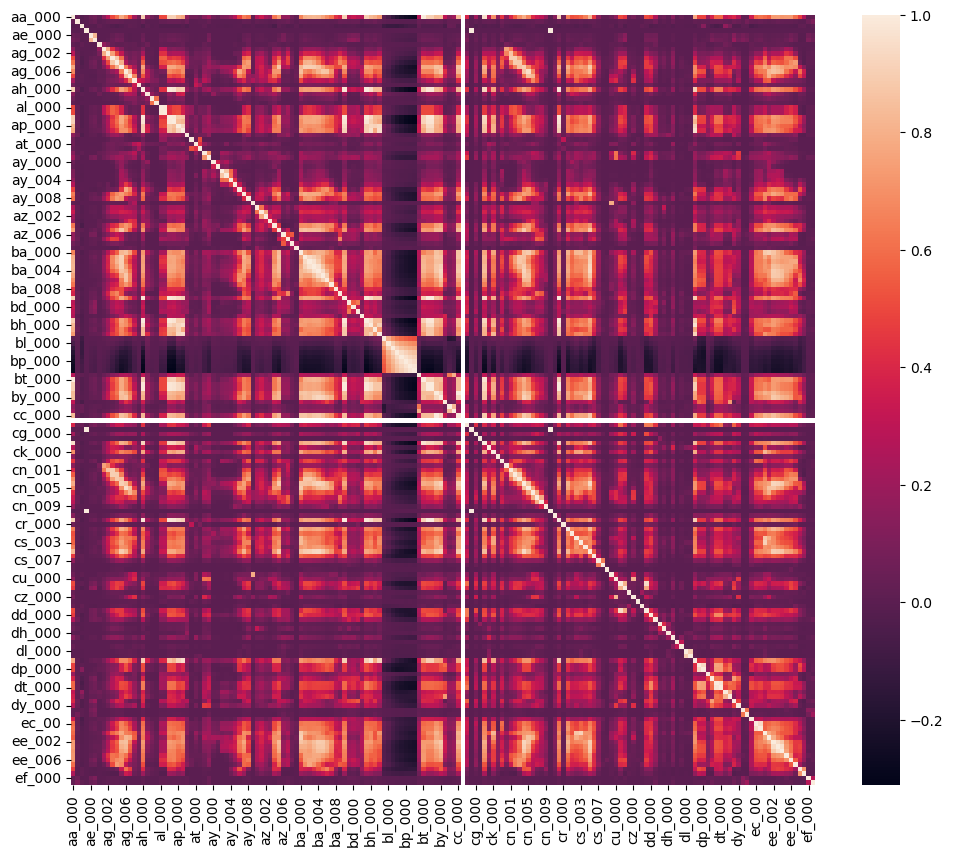

In [17]:
plt.figure(figsize = (12, 10))
correlation_matrix = imputed_train_x_df.corr()
sns.heatmap(correlation_matrix)
plt.show()

### iv. Pick |√170| features with highest CV, and make scatter plots and box plots for them, similar to those on p. 129 of ISLR. Can you draw conclusions about significance of those features, just by the scatter plots? This does not mean that you will only use those features in the following questions. We picked them only for visualization.

In [19]:
top_cv = cv.sort_values(ascending = False)[:math.floor(math.sqrt(170))]
top_cv.to_frame(name='Top CV')

,Top CV
cs_009,235.277605
cf_000,184.233092
co_000,183.949017
ad_000,183.847620
dh_000,114.984991
dj_000,109.647285
ag_000,91.878565
as_000,86.416904
ay_009,83.786063
az_009,76.967978


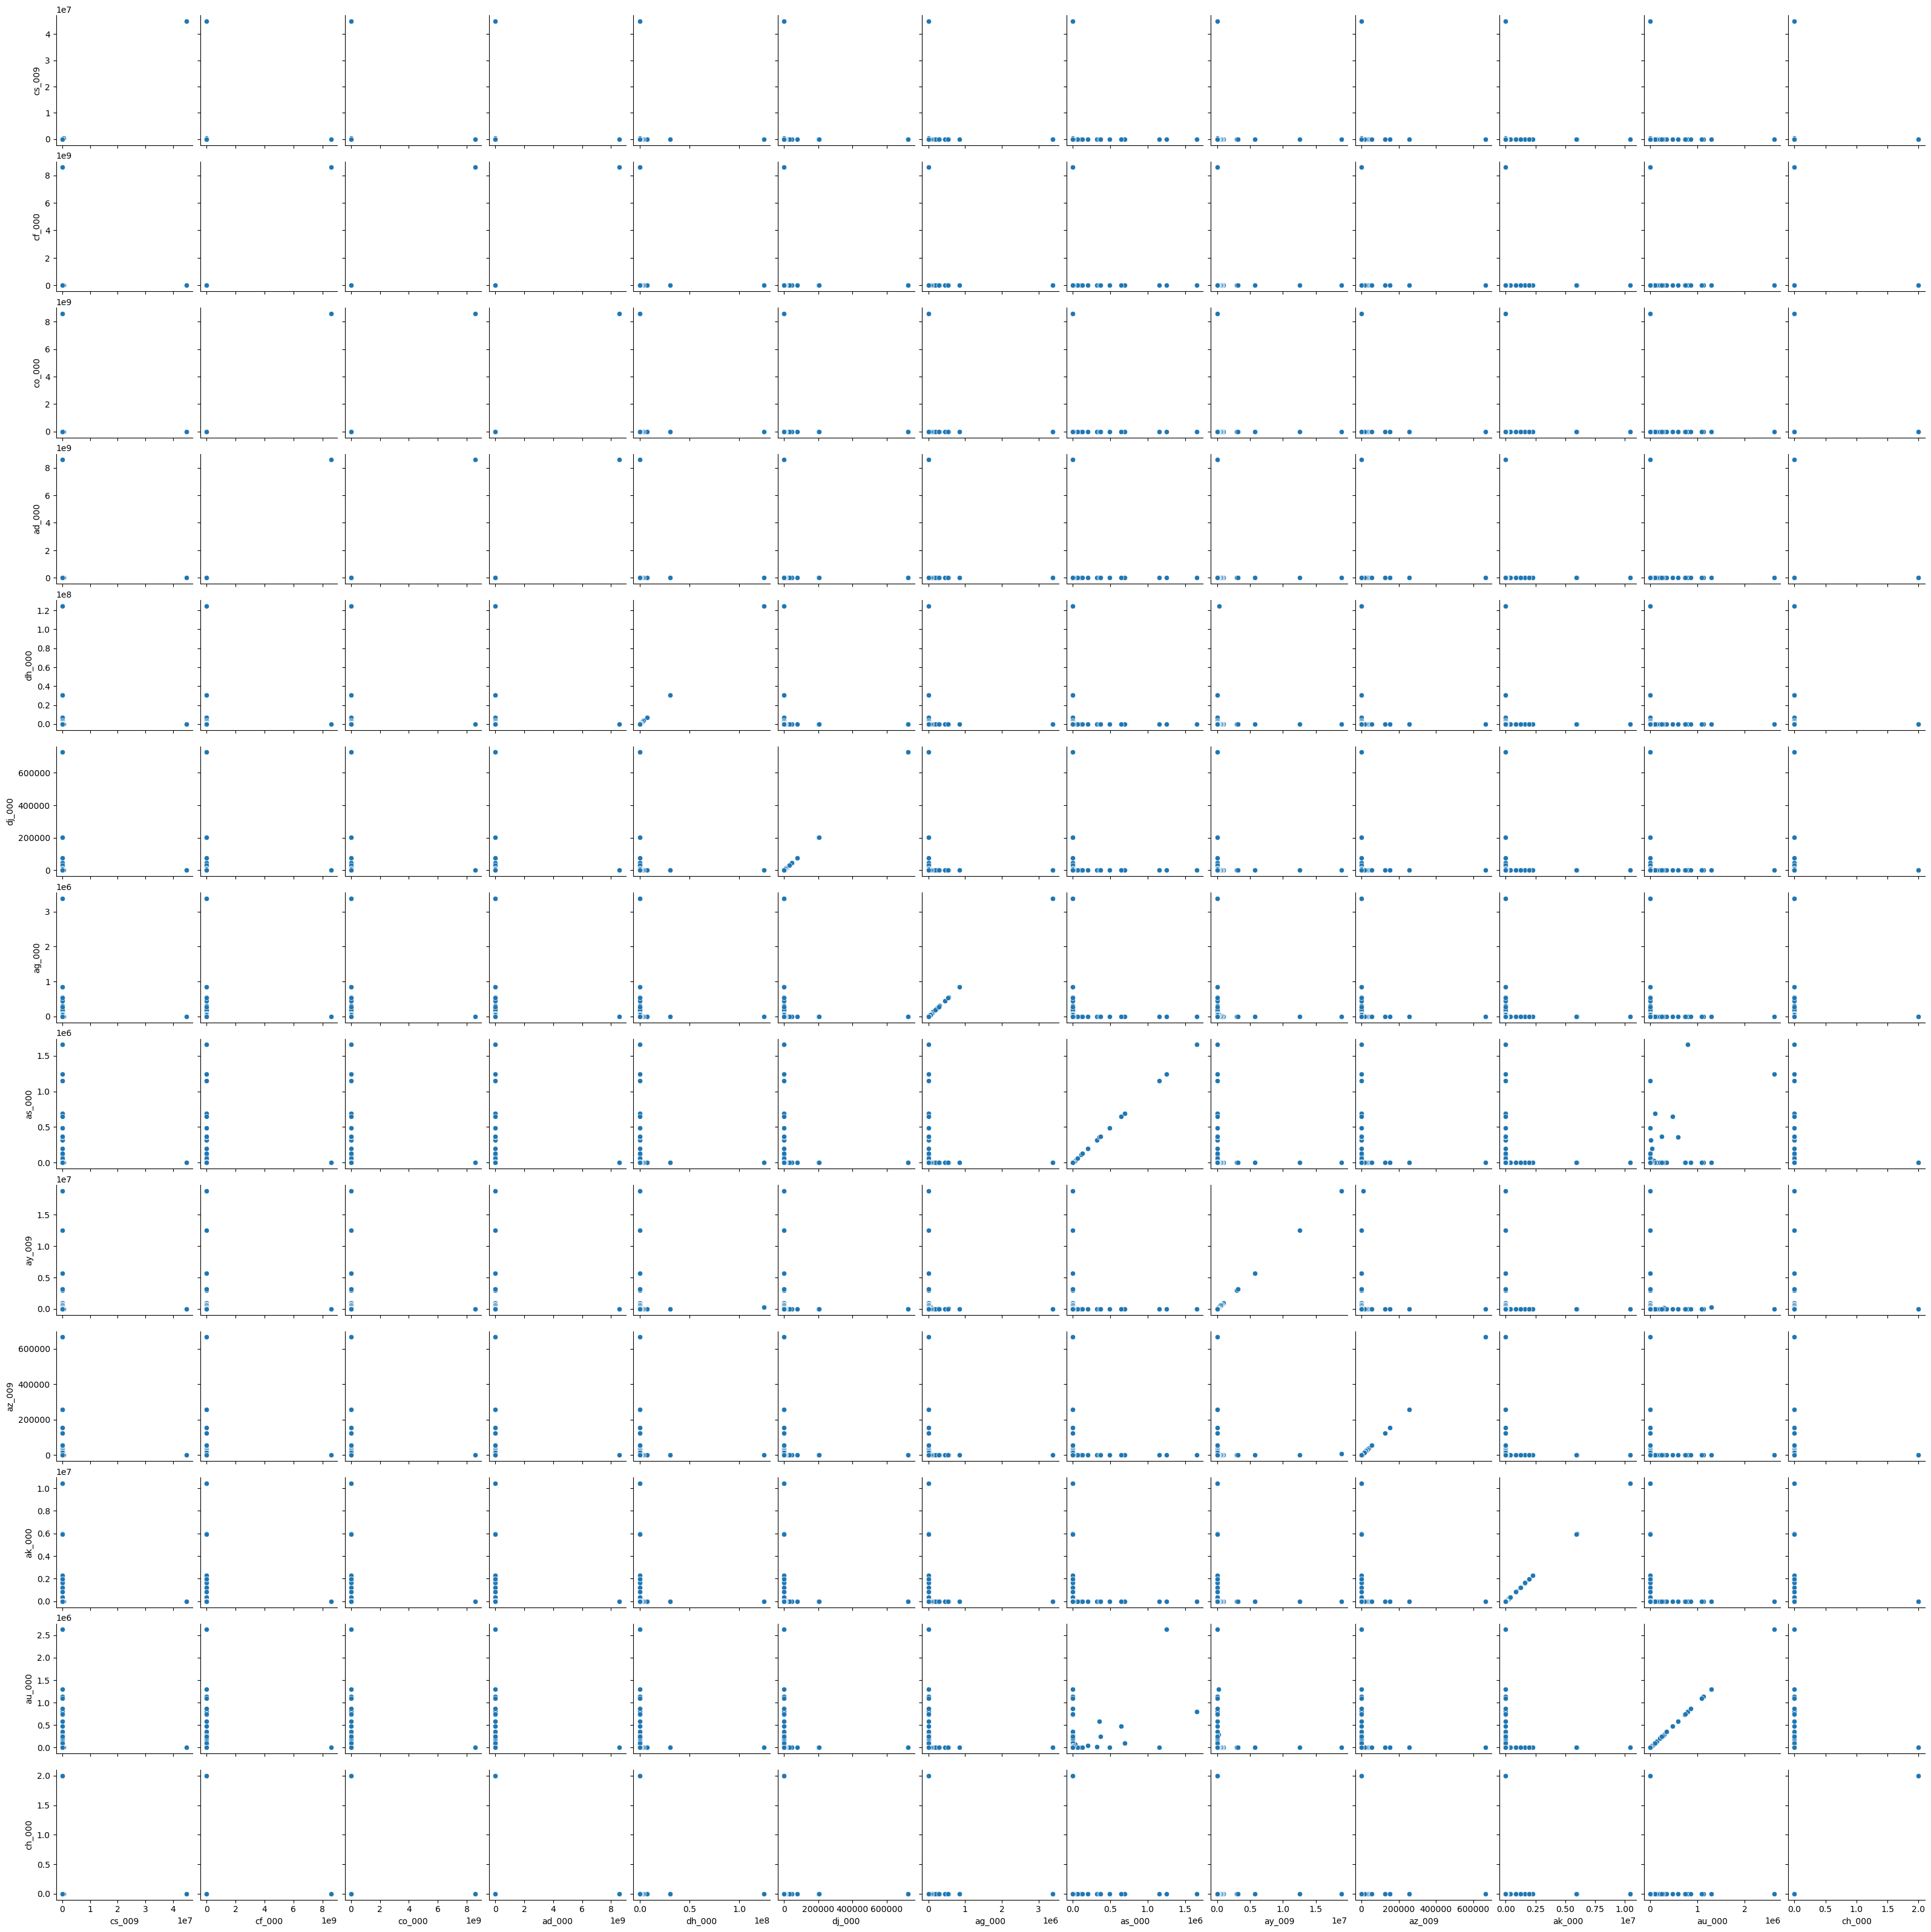

In [20]:
sns.pairplot(imputed_train_x_df[top_cv.index], diag_kind=None)
plt.show()

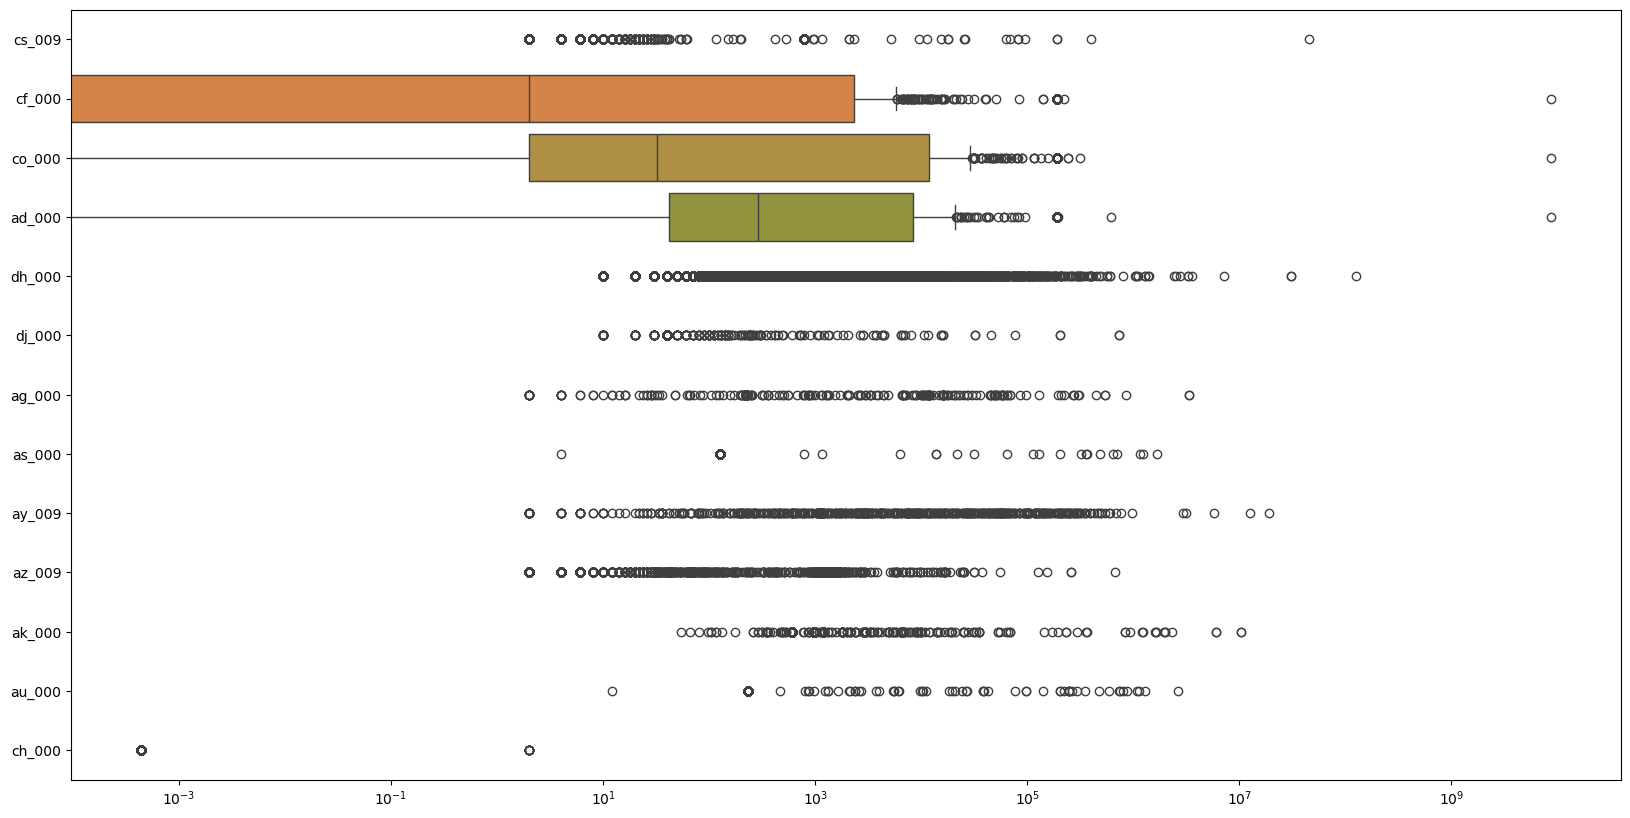

In [21]:
fig, axes = plt.subplots(figsize=(20, 10))
box = sns.boxplot(data=imputed_train_x_df[top_cv.index.to_list()], ax=axes, orient='h')
box.set(xscale='log')
plt.show()

We can not determine this dataset is imbalanced using boxplots or scatterplots. This is because any outlier can affect the datapoints easily since we used mean.

### v. Determine the number of positive and negative data. Is this data set imbalanced?

In [24]:
train_counts = train_y.value_counts()
test_counts = test_y.value_counts()

train_counts, test_counts

(class
 0        59000
 1         1000
 Name: count, dtype: int64,
 class
 0        15625
 1          375
 Name: count, dtype: int64)

In [25]:
print(f'The number of positive train data is {train_counts.iloc[1]}')
print(f'The number of negative train data is {train_counts.iloc[0]}')
print(f'The number of positive test data is {test_counts.iloc[1]}')
print(f'The number of negative test data is {test_counts.iloc[0]}')
print('We can confirm that this data set is imbalanced.')

The number of positive train data is 1000
The number of negative train data is 59000
The number of positive test data is 375
The number of negative test data is 15625
We can confirm that this data set is imbalanced.


## (c) Train a random forest to classify the data set. Do NOT compensate for class imbalance in the data set. Calculate the confusion matrix, ROC, AUC, and misclassification for training and test sets and report them (You may use pROC package). Calculate Out of Bag error estimate for your random forset and compare it to the test error.

In [27]:
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
# Source: homework #4
def plot_ROC_curve(true, pred, prob):
    score = accuracy_score(true, pred)
    cm = confusion_matrix(true, pred)
    roc_auc = roc_auc_score(true, prob)
    fpr, tpr, thresholds = roc_curve(true, prob)
    auc_ = auc(fpr, tpr)
    
    print(f'Accuarcy score : {score}')
    print(f'Confusion matrix: \n{cm}')
    print(f'ROC AUC score: {roc_auc}')
    print(f'AUC: {auc_}\n')
        
    plt.figure()
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # 45-degree line for random guessing
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

In [28]:
train_y

,class
0,0
1,0
2,0
3,0
4,0
...,...
59995,0
59996,0
59997,0
59998,0


In [29]:
# Source: https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.RandomForestClassifier.html
clf = RandomForestClassifier(max_depth=5, random_state=60000, oob_score=True)
clf.fit(imputed_train_x_df, train_y.values.ravel())

RandomForestClassifier(max_depth=5, oob_score=True, random_state=60000)

In [30]:
train_y_pred = clf.predict(imputed_train_x_df)
train_y_prob = clf.predict_proba(imputed_train_x_df)[:, 1]

Accuarcy score : 0.9920333333333333
Confusion matrix: 
[[58972    28]
 [  450   550]]
ROC AUC score: 0.9868075254237288
AUC: 0.9868075254237288



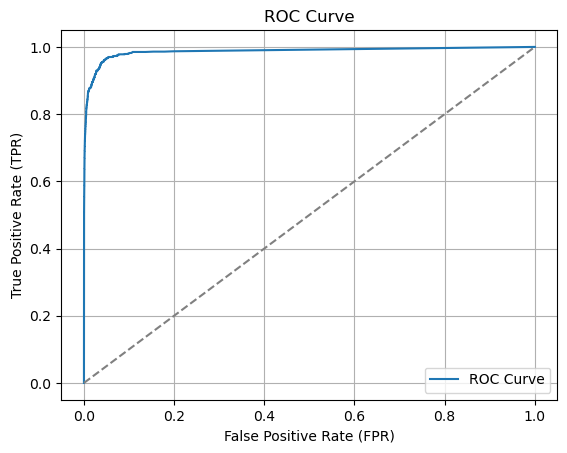

In [31]:
plot_ROC_curve(train_y, train_y_pred, train_y_prob)

In [32]:
test_y_pred = clf.predict(imputed_test_x_df)
test_y_prob = clf.predict_proba(imputed_test_x_df)[:,1]

Accuarcy score : 0.9879375
Confusion matrix: 
[[15612    13]
 [  180   195]]
ROC AUC score: 0.9941294933333333
AUC: 0.9941294933333333



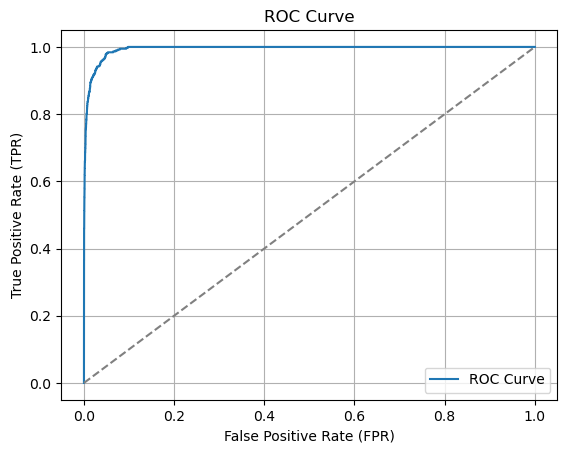

In [33]:
plot_ROC_curve(test_y, test_y_pred, test_y_prob)

In [34]:
print(f'Out of Bag error estimate: {1-clf.oob_score_}')

Out of Bag error estimate: 0.009366666666666634


In [35]:
print(f'Test error: {1-accuracy_score(test_y, test_y_pred)}')

Test error: 0.012062499999999976


## (d) Research how class imbalance is addressed in random forests. Compensate for class imbalance in your random forest and repeat 1c. Compare the results with thos of 1c.

1. Class Weighting: Random forest in sklearn can adjust the weight of each class. By setting ```class_weight="balanced"```, the algorithm automatically weights the classes inversely proportional to their frequencies in the data. This adjustment penalizes the misclassification of minority classes, helping the model better recognize them.
2. Oversampling/Undersamping: Synthetic Minority Over-sampling Technique(SMOTE) can be sued to create synthetic smaples for the minority class, increasing the overall representation of that class in the data.
3. Balanced Random Forest: Balanced Random Forest(BRF) are an extension wher each tree is trained on the balanced bootstrap sample by undersampling the majority to match the amount of the minority class.

Reference:  
[1] Huh, K. "Surviving in a Random Forest with Imbalanced Datasets." Medium. Available online: https://medium. com/sfu-cspmp/surviving-in-a-random-forest-with-imbalanced-datasets-b98b963d52eb (accessed on 2 September 2024) (2021).  
[2] Chen, Chao, Andy Liaw, and Leo Breiman. "Using random forest to learn imbalanced data." University of California, Berkeley 110.1-12 (2004): 24.  

In [38]:
balanced_clf = RandomForestClassifier(max_depth=5, random_state=60000, class_weight='balanced', oob_score=True)
balanced_clf.fit(imputed_train_x_df, train_y.values.ravel())

RandomForestClassifier(class_weight='balanced', max_depth=5, oob_score=True,
                       random_state=60000)

In [39]:
balanced_train_y_pred = clf.predict(imputed_train_x_df)
balanced_train_y_prob = clf.predict_proba(imputed_train_x_df)[:, 1]

Accuarcy score : 0.9920333333333333
Confusion matrix: 
[[58972    28]
 [  450   550]]
ROC AUC score: 0.9868075254237288
AUC: 0.9868075254237288



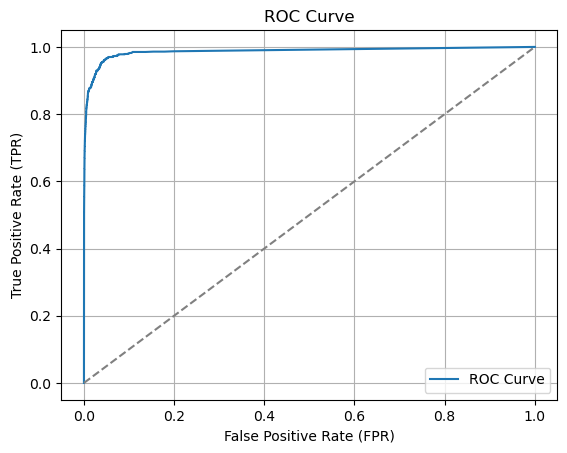

In [40]:
plot_ROC_curve(train_y, balanced_train_y_pred, balanced_train_y_prob)

In [41]:
balanced_test_y_pred = clf.predict(imputed_test_x_df)
balanced_test_y_prob = clf.predict_proba(imputed_test_x_df)[:,1]

Accuarcy score : 0.9879375
Confusion matrix: 
[[15612    13]
 [  180   195]]
ROC AUC score: 0.9941294933333333
AUC: 0.9941294933333333



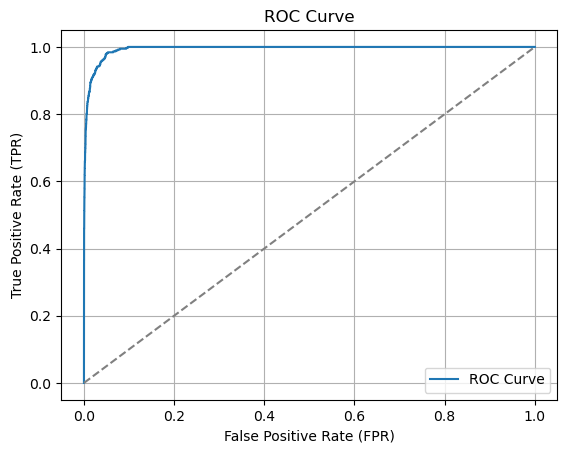

In [42]:
plot_ROC_curve(test_y, balanced_test_y_pred, balanced_test_y_prob)

In [43]:
print(f'Out of Bag error estimate: {1-balanced_clf.oob_score_}')

Out of Bag error estimate: 0.04244999999999999


In [44]:
print(f'Test error: {1-accuracy_score(test_y, balanced_test_y_pred)}')

Test error: 0.012062499999999976


The OOB error increased compared to the imbalanced dataset, however, the difference appears minimal.
The class imbalance issue has been resolved.

### (e) XGBoost and Model Trees

In the case of a univariate tree, only one input dimension is used at a tree split. In a multivariate tree, or model tree, at a decision node all input dimensions can be used and thus it is more general. In univariate classification trees, majority polling is used at each node to determine the split of that node as the decision rule. In model trees, a (linear) model that relies on all of the variables is used to determine the split of that node. Alternatively, in a regression tree, instead of using average in the region associated with each node, a linear regression model is used to determine the value associated with that node. One of the methods that can be used at each node is Logistic Regression. Because the number of variables is large in this problem, one can use
L1-penalized logistic regression at each node. You can use XGBoost to fit the model tree. Determine α (the regularization term)  using cross-validation. Train the model for the APS data set without compensation for class imbalance. Use one of 5 fold, 10 fold,
and leave-one-out cross validation methods to estimate the error of your trained model and compare it with the test error. Report the Confusion Matrix, ROC, and AUC for training and test sets.

In [48]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
param_grid = {'reg_alpha': alphas}
scaler = StandardScaler()
scaled_train_x = pd.DataFrame(scaler.fit_transform(imputed_train_x_df),columns=imputed_train_x_df.columns)
scaled_test_x = pd.DataFrame(scaler.fit_transform(imputed_test_x_df),columns=imputed_test_x_df.columns)

In [49]:
# Source: https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier
xgb = XGBClassifier(objective='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, eval_metric="logloss")

In [50]:
# Source: https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html
grid_search_cv = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=5) #5-fold
grid_search_cv.fit(scaled_train_x, train_y)
best_alpha = grid_search_cv.best_params_['reg_alpha']
print(f'The best alpah value is {best_alpha} and the best score is {grid_search_cv.best_score_}')

The best alpah value is 1 and the best score is 0.9942


In [51]:
xgb_w_best_alpha = XGBClassifier(objective="binary:logistic", reg_alpha=best_alpha, learning_rate=0.1, colsample_bytree = 0.3, max_depth=5, eval_metric="logloss")
xgb_w_best_alpha.fit(scaled_train_x, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

Training result of XGBoost with best alpha(1)
Accuarcy score : 0.9979666666666667
Confusion matrix: 
[[58990    10]
 [  112   888]]
ROC AUC score: 0.9987710084745762
AUC: 0.9987710084745762



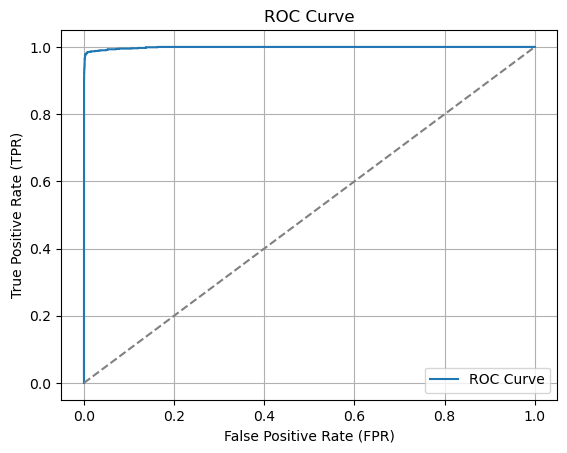

In [52]:
print(f'Training result of XGBoost with best alpha({best_alpha})')
xgb_train_y_pred = xgb_w_best_alpha.predict(scaled_train_x)
xgb_train_y_prob = xgb_w_best_alpha.predict_proba(scaled_train_x)[:,1]
plot_ROC_curve(train_y, xgb_train_y_pred, xgb_train_y_prob)

Testing result of XGBoost with best alpha(1)
Accuarcy score : 0.992
Confusion matrix: 
[[15608    17]
 [  111   264]]
ROC AUC score: 0.9957405013333334
AUC: 0.9957405013333334



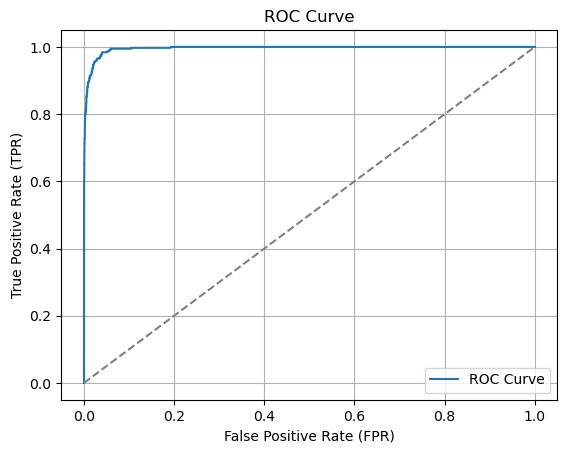

In [53]:
print(f'Testing result of XGBoost with best alpha({best_alpha})')
xgb_test_y_pred = xgb_w_best_alpha.predict(scaled_test_x)
xgb_test_y_prob = xgb_w_best_alpha.predict_proba(scaled_test_x)[:,1]
plot_ROC_curve(test_y, xgb_test_y_pred, xgb_test_y_prob)

### (f) Use SMOTE (Synthetic Minority Over-sampling Technique) to pre-process you data to compensate for class imbalance. Train L1-penalized logistic regression at each node using the pre-processed data and repeat 1e. Do not forget that there is a right and a wrong way of cross validation here. Compare the uncompensated case with SMOTE case.

In [55]:
pipeline = Pipeline( steps = [
    ['smote', SMOTE(random_state=42)],
    ['xgbclassifier', xgb]
])
param_grid = {'xgbclassifier__reg_alpha': alphas}

smote_grid_search_cv = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
smote_grid_search_cv.fit(scaled_train_x, train_y['class'])

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[['smote', SMOTE(random_state=42)],
                                       ['xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=0.3,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='logloss',
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None...
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=5,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...)]]),
             n_jobs=-1,
             param_grid={'xgbclassifier__reg_alpha': [0.001, 0.005, 0.01, 0.05,
                                                      0.1, 0.5, 1, 5, 10, 50,
                                                      100]},
             scoring='accuracy')

In [56]:
smote_best_alpha = smote_grid_search_cv.best_params_['xgbclassifier__reg_alpha']
print(f'The best alpah value is {smote_best_alpha} and the best score is {smote_grid_search_cv.best_score_}')

The best alpah value is 0.01 and the best score is 0.9889833333333333


In [57]:
smote_xgb_w_best_alpha = XGBClassifier(objective="binary:logistic", reg_alpha=smote_best_alpha, learning_rate=0.1, colsample_bytree = 0.3, max_depth=5, eval_metric="logloss")
smote_xgb_w_best_alpha.fit(scaled_train_x, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

Training result of SMOTE with best alpha(0.01)
Accuarcy score : 0.99815
Confusion matrix: 
[[58993     7]
 [  104   896]]
ROC AUC score: 0.9991114322033898
AUC: 0.9991114322033898



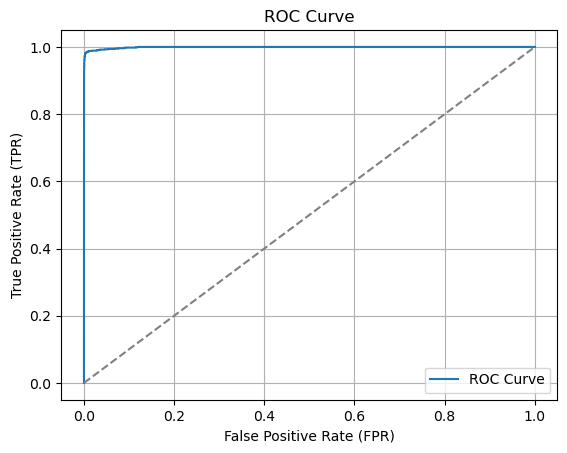

In [58]:
print(f'Training result of SMOTE with best alpha({smote_best_alpha})')
smote_xgb_train_y_pred = smote_xgb_w_best_alpha.predict(scaled_train_x)
smote_xgb_train_y_prob = smote_xgb_w_best_alpha.predict_proba(scaled_train_x)[:,1]
plot_ROC_curve(train_y, smote_xgb_train_y_pred, smote_xgb_train_y_prob)

Testing result of SMOTE with best alpha(0.01)
Accuarcy score : 0.99175
Confusion matrix: 
[[15608    17]
 [  115   260]]
ROC AUC score: 0.9954945706666667
AUC: 0.9954945706666667



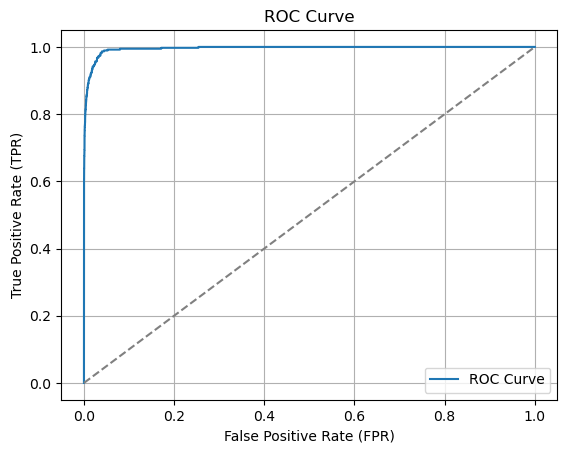

In [59]:
print(f'Testing result of SMOTE with best alpha({smote_best_alpha})')
smote_xgb_test_y_pred = smote_xgb_w_best_alpha.predict(scaled_test_x)
smote_xgb_test_y_prob = smote_xgb_w_best_alpha.predict_proba(scaled_test_x)[:,1]
plot_ROC_curve(test_y, smote_xgb_test_y_pred, smote_xgb_test_y_prob)

# 2. ISLR 6.6.3

(a) The training RSS would steadily decrease. As s increases, the constraint on the coefficients loosens. Thus, the training RSS will decrease as the model becomes flexible.  
(b) The test RSS will decrease initially, and then eventually start increasing in a U shape. When s increases, the model becomes more flexible and RSS would be decreased. However, beyond a certain point, increasing s further causes overfitting to the training data, which then leads to an increase.  
(c) The variance will steadily increase. This is because the model fit more to the particularities of the training data, causing to a more complex model with greater variance.  
(d) The bias will steadily decrease. This is because when s is very small, the coefficients become more contrained, and the model becomes simple with high variance. As s increases, the model can better fit the data, reducing the bias.  
(e) The irreducible error will remain constant. This is because the irreducible error represents noise or randomness in the data that cannot be reduced by adjusting the model.  

# 3. ISLR 6.6.5

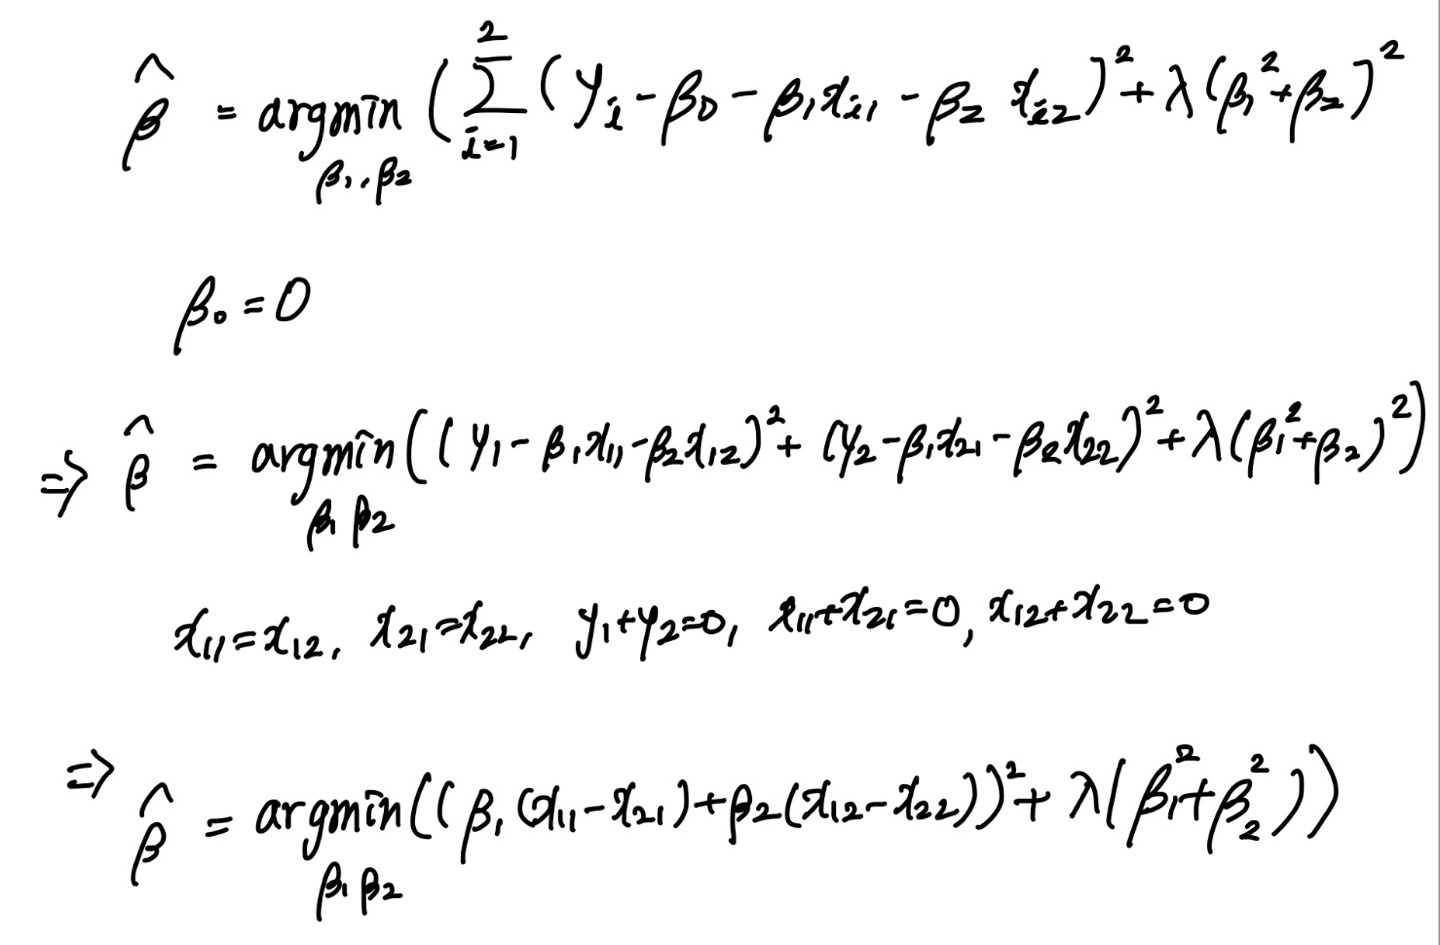

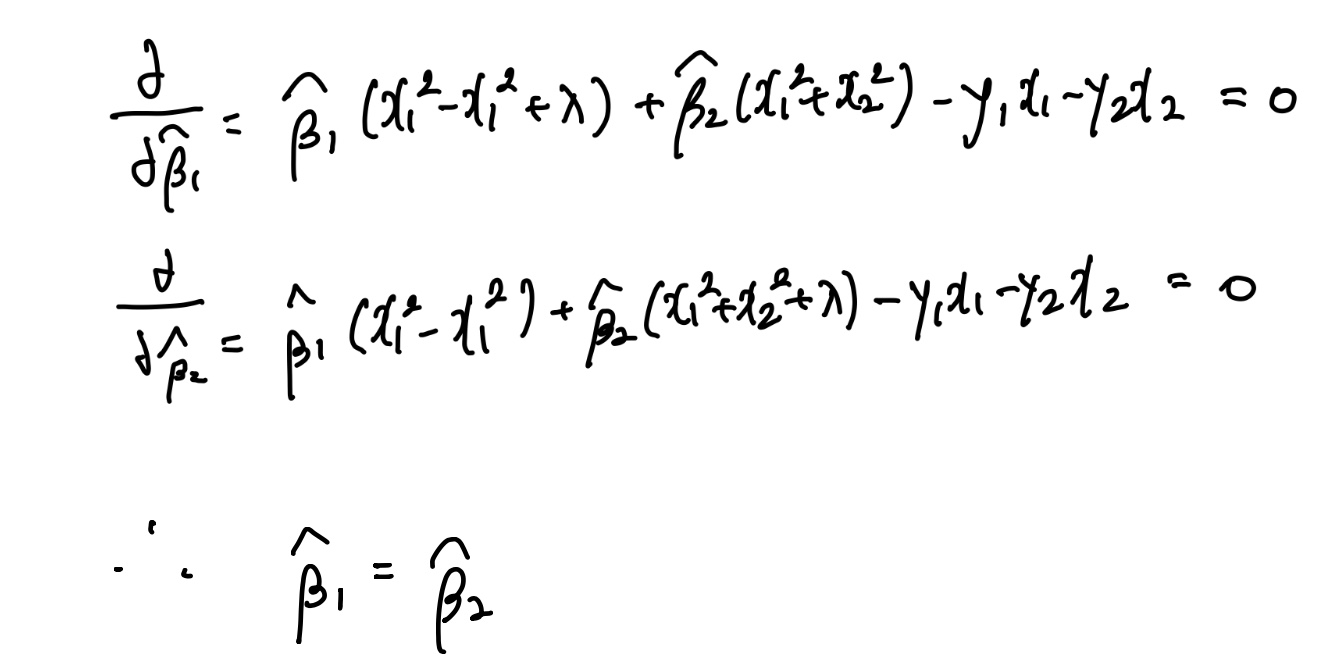

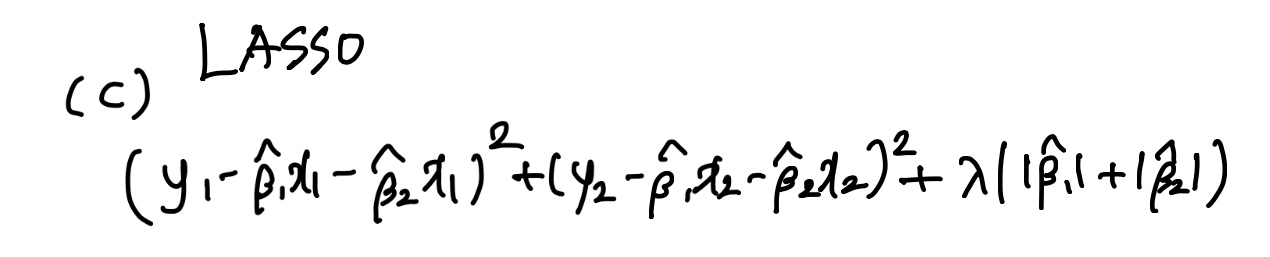

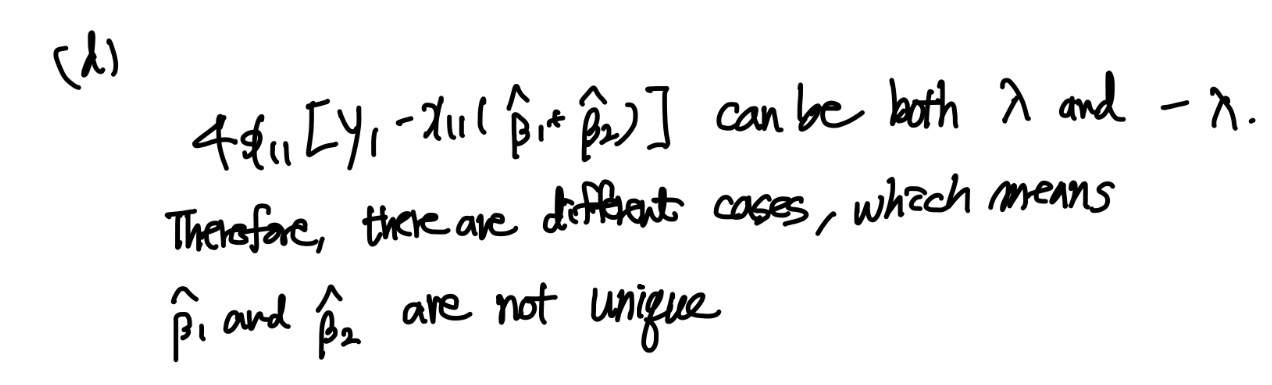

# 4. ISLR 8.4.5

Majority polling: X is classified as red. P(Red|X)<0.5 = 4 vs. P(Red|X)>0.5 = 6.   
Avergae probability: X is classified as green. P(Red|X) = 0.45

# 5. ISLR 9.7.3

## (a)

In [71]:
x1 = [3, 2, 4, 1, 2, 4, 4]
x2 = [4, 2, 4, 4, 1, 3, 1]
colors = ["red", "red", "red", "red", "blue", "blue", "blue"]

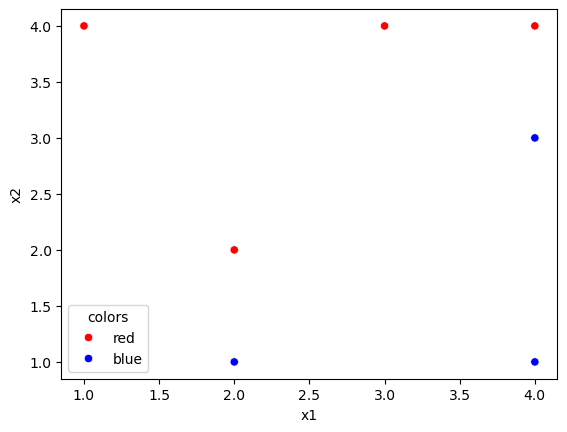

In [72]:
df = pd.DataFrame(dict(x1=x1, x2=x2, colors=colors))
sns.scatterplot(df, x='x1', y='x2', hue='colors', palette=['red','blue'])
plt.show()

## (b) 

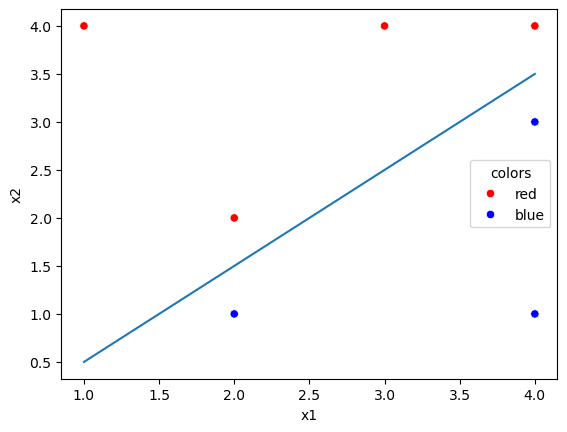

In [74]:
x = [1, 2, 3, 4]
y = [0.5, 1.5, 2.5, 3.5]
plt.plot(x, y)
sns.scatterplot(df, x='x1', y='x2', hue='colors', palette=['red','blue'])
plt.show()

## (c)

Classified as red if x1 - x2 - 0.5 < 0   
Otherwise, classify to blue b0 = -0.5, b1 = 1, b2 = -1  

## (d) 

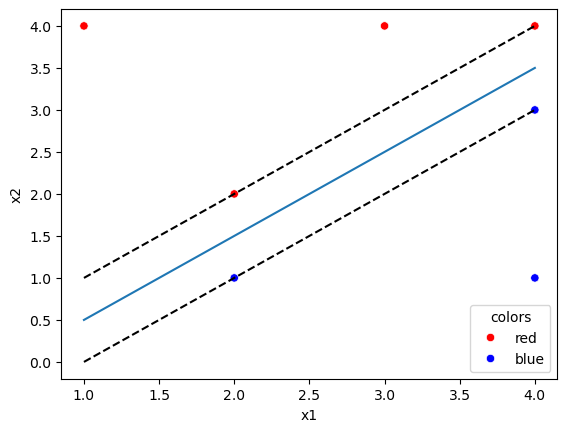

In [78]:
y1 = [i-1 for i in x]
y2 = [i for i in x]

plt.plot(x, y)
plt.plot(x, y1, 'k--')
plt.plot(x, y2, 'k--')
sns.scatterplot(df, x='x1', y='x2', hue='colors', palette=['red','blue'])
plt.show()

## (e)

The support vector is Red: (2,2) and (4,4) & Blue: (2,1) and (4,3)

## (f)

A slight movement of the seventh observation is not the support vector. When it moves slightly, it would not affect the maximum margin hyperplane. The support vector algorithm depends on the support vectors to define the hyperplane, and small changes to non-support vectors or minor pertubations of support vectors typically do not affect the final model.  

Reference:  
An Introduction to Statistical Learning

## (g)

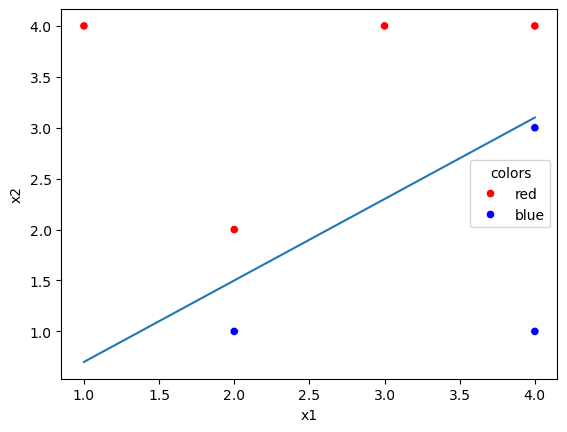

In [84]:
y = [0.8*i-0.1 for i in x]
plt.plot(x, y)
sns.scatterplot(df, x='x1', y='x2', hue='colors', palette=['red','blue'])
plt.show()

Equation: X2 = 0.8X1 - 0.1  
This would not be the optimal result.

## (h)

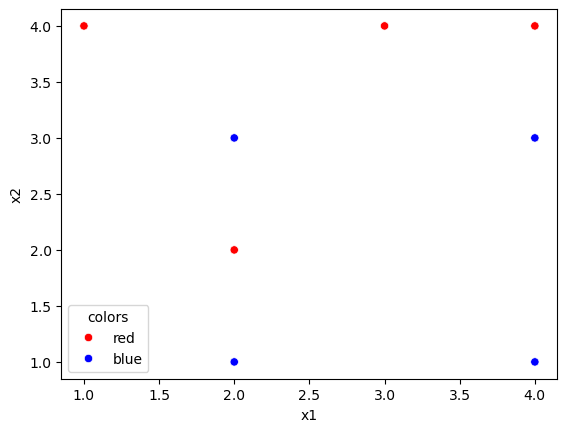

In [87]:
x1 = [3, 2, 4, 1, 2, 4, 4, 2]
x2 = [4, 2, 4, 4, 1, 3, 1, 3]
colors = ["red", "red", "red", "red", "blue", "blue", "blue", "blue"]
df = pd.DataFrame(dict(x1=x1, x2=x2, colors=colors))
sns.scatterplot(data=df, x='x1', y='x2', hue='colors', palette=['red','blue'])
plt.show()

When we put (2,3) as above image, the two classes are no longer separable by a hyperplane.